In [519]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 
import numpy as np 
import pandas as pd 
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import sklearn.tree as tree
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [520]:
df = pd.read_csv('/content/forestfires.csv')
df.head()
df=df.drop(columns=['X','Y','day'])


In [521]:
def damage_func(area):
    if area == 0.0:
        return 0
    else:
        return 1

df['damage'] = df['area'].apply(damage_func)

In [522]:
df1 = pd.read_csv('/content/Algerian_forest_fires_dataset_UPDATE.csv')

In [523]:
print(df.columns,"/n",df1.columns)

Index(['month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'damage'],
      dtype='object') /n Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')


In [524]:
month_dict = {'mar': 3, 'oct': 10, 'aug': 8, 'sep': 9, 'apr': 4, 'jun': 6, 'jul': 7,
              'feb': 2, 'jan': 1, 'dec': 12, 'may': 5, 'nov': 11}
day_dict = {'fri': 5, 'tue': 2, 'sat': 6, 'sun': 7, 'mon': 1, 'wed': 3, 'thu': 4}


In [525]:
df.replace(month_dict.keys(),month_dict.values(),inplace=True)
df.replace(day_dict.keys(),day_dict.values(),inplace=True)
df.head()

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage
0,3,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0
1,10,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0
2,10,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0
3,3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0
4,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0


In [526]:
new_column_names = {'Temperature': 'temp', 'Rain ': 'rain','Classes  ':'damage',' RH':'RH',' Ws':'wind'}
df1 = df1.rename(columns=new_column_names)

In [527]:
df1.head()

,day,month,year,temp,RH,wind,rain,FFMC,DMC,DC,ISI,BUI,FWI,damage
0,1,6,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,5,6,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [528]:
df1['damage'][0]

'not fire   '

In [529]:
def damage_func1(damage):
    if damage == 'not fire   ':
        return 0
    else:
        return 1

df1['damage'] = df1['damage'].apply(damage_func1)

In [530]:
df1.head()

,day,month,year,temp,RH,wind,rain,FFMC,DMC,DC,ISI,BUI,FWI,damage
0,1,6,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,0
4,5,6,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,0


In [531]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   517 non-null    int64  
 1   FFMC    517 non-null    float64
 2   DMC     517 non-null    float64
 3   DC      517 non-null    float64
 4   ISI     517 non-null    float64
 5   temp    517 non-null    float64
 6   RH      517 non-null    int64  
 7   wind    517 non-null    float64
 8   rain    517 non-null    float64
 9   area    517 non-null    float64
 10  damage  517 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 44.6 KB


In [532]:
df1=df1.drop(columns=['day','BUI','FWI','year'])
display(df.dtypes)
display(df1.dtypes)


month       int64
FFMC      float64
DMC       float64
DC        float64
ISI       float64
temp      float64
RH          int64
wind      float64
rain      float64
area      float64
damage      int64
dtype: object

month     object
temp      object
RH        object
wind      object
rain      object
FFMC      object
DMC       object
DC        object
ISI       object
damage     int64
dtype: object

In [533]:
df1.isna().sum()
df1=df1.dropna()
df1.isna().sum()

month     0
temp      0
RH        0
wind      0
rain      0
FFMC      0
DMC       0
DC        0
ISI       0
damage    0
dtype: int64

In [534]:
# Replace non-numeric values with NaN
df1['month'] = pd.to_numeric(df1['month'], errors='coerce')

# Drop rows with missing values in 'month' column
df1 = df1.dropna(subset=['month'])


In [535]:
df1_copy = df1.copy()
df1_copy.loc[:, 'month'] = df1_copy['month'].astype('int64')
df1_copy.loc[:, 'temp'] = df1_copy['temp'].astype('float64')
df1_copy.loc[:, 'RH'] = df1_copy['RH'].astype('int64')
df1_copy.loc[:, 'wind'] = df1_copy['wind'].astype('float64')
df1_copy.loc[:, 'rain'] = df1_copy['rain'].astype('float64')
df1_copy.loc[:, 'FFMC'] = df1_copy['FFMC'].astype('float64')
df1_copy.loc[:, 'DMC'] = df1_copy['DMC'].astype('float64')
df1_copy.loc[:, 'DC'] = pd.to_numeric(df1_copy['DC'], errors='coerce').astype('float64')
df1_copy.loc[:, 'ISI'] = pd.to_numeric(df1_copy['ISI'], errors='coerce').astype('float64')
df1_copy=df1_copy.dropna()

<ipython-input-535-2b8406caf9cf>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df1_copy.loc[:, 'month'] = df1_copy['month'].astype('int64')
<ipython-input-535-2b8406caf9cf>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df1_copy.loc[:, 'temp'] = df1_copy['temp'].astype('float64')
<ipython-input-535-2b8406caf9cf>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if col

In [536]:
display(df1_copy.dtypes)

month       int64
temp      float64
RH          int64
wind      float64
rain      float64
FFMC      float64
DMC       float64
DC        float64
ISI       float64
damage      int64
dtype: object

In [537]:
df = pd.concat([df, df1_copy], ignore_index=True)

In [538]:
df

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage
0,3,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0
1,10,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0
2,10,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0
3,3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0
4,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
755,9,85.4,16.0,44.5,4.5,30.0,65,14.0,0.0,NaN,1
756,9,41.1,6.5,8.0,0.1,28.0,87,15.0,4.4,NaN,0
757,9,45.9,3.5,7.9,0.4,27.0,87,29.0,0.5,NaN,0
758,9,79.7,4.3,15.2,1.7,24.0,54,18.0,0.1,NaN,0


# Features

In [539]:
df=df.drop(columns='area')
df.head()

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,damage
0,3,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
1,10,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
2,10,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
3,3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
4,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0


In [540]:
# # Categorical: Month and day
# df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

# Model Building

After model fitting, I apply the reverse log transform, to compare with test data (RMSE has same units as target, and it's more intuitive to report in units of area rather than log area).

In [541]:

df=df.dropna()
# Creating bins of in the target, to stratify in train/test split
df['damage_bin'] = pd.cut(df['damage'], 5)
X = df.drop(columns='damage') 
y = df['damage']


First, there is a bit of an issue due to the dataset's small size. I noticed setting a random seed for reproducibility had a large affect on the final model and predictions. I illustrate this below:

In [542]:
rs = 99
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=rs,
                                                   stratify=df[['damage_bin']])
X_train = X_train.drop(columns='damage_bin',axis=1)
X_test = X_test.drop(columns='damage_bin',axis=1)

# Baseline Models

**Random Forest**

In [543]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestRegressor()
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
pipe1 = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)
pipe1.fit(X_train, Y_train)

y_pred1 = pipe1.predict(X_test)
y_pred = rf.predict(X_test)

print(accuracy_score(Y_test, y_pred1))
print(accuracy_score(Y_test, y_pred))

0.6776315789473685
0.6842105263157895


In [544]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, Y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6052631578947368


In [545]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [546]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, Y_train)
y_pred = logreg_classifier.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)



Accuracy: 0.6578947368421053


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [547]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


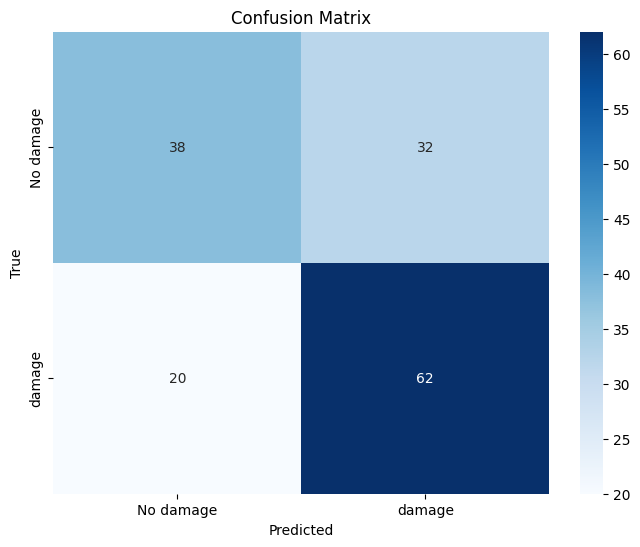

In [548]:
cm = confusion_matrix(Y_test, y_pred)
class_labels = ['No damage', 'damage']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [549]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [550]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
pipe.fit(X_train, Y_train)
y_pred = pipe.predict(X_test)


In [551]:
accuracy = accuracy_score(Y_test, y_pred)

In [552]:
accuracy

0.6513157894736842

In [553]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a Decision Tree Classifier object
clf = DecisionTreeClassifier(criterion='gini', splitter='best')
clf.fit(X_train, Y_train)
accuracy = accuracy_score(Y_test, y_pred)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy)

Accuracy: 0.6513157894736842


In [555]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a Random Forest Classifier object
rf_classifier = RandomForestClassifier(n_estimators=100)

# Create an AdaBoost Classifier object with the Random Forest Classifier as the base estimator
adaboost_classifier = AdaBoostClassifier(base_estimator=rf_classifier, n_estimators=50)


# Train the AdaBoost classifier on the training data
adaboost_classifier.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = adaboost_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.6644736842105263
